In [1]:
import json
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pathlib import Path

In [2]:
def create_graphs(checkpoint: str):
    def create_graph(file_path):
        with open(file_path) as f:
            data = json.load(f) 

        G = nx.DiGraph()   

        for node, attrs in data["nodes"].items():
            G.add_node(node, **attrs)  

        for edge_str, attrs in data["edges"].items():
            if "->" in edge_str:
                src, tgt = edge_str.split("->", 1)
                G.add_edge(src, tgt, weight=attrs.get('score', 0.0), **attrs)
            else:
                print(f"Warning: skipped malformed edge key: {edge_str}")
        return G

    G0 = create_graph(f"results-04-07-25/checkpoint-{checkpoint}/prompt_template_0/graph.json")
    G1 = create_graph(f"results-04-07-25/checkpoint-{checkpoint}/prompt_template_1/graph.json")
    G2 = create_graph(f"results-04-07-25/checkpoint-{checkpoint}/prompt_template_2/graph.json")
    G3 = create_graph(f"results-04-07-25/checkpoint-{checkpoint}/prompt_template_3/graph.json")
    G4 = create_graph(f"results-04-07-25/checkpoint-{checkpoint}/prompt_template_4/graph.json")
    G5 = create_graph(f"results-04-07-25/checkpoint-{checkpoint}/prompt_template_5/graph.json")
    G6 = create_graph(f"results-04-07-25/checkpoint-{checkpoint}/prompt_template_6/graph.json")
    G7 = create_graph(f"results-04-07-25/checkpoint-{checkpoint}/prompt_template_7/graph.json")
    G8 = create_graph(f"results-04-07-25/checkpoint-{checkpoint}/prompt_template_8/graph.json")
    G9 = create_graph(f"results-04-07-25/checkpoint-{checkpoint}/prompt_template_9/graph.json")

    graphs = [
    ('G0', G0),
    ('G1', G1),
    ('G2', G2),
    ('G3', G3),
    ('G4', G4),
    ('G5', G5),
    ('G6', G6),
    ('G7', G7),
    ('G8', G8),
    ('G9', G9),
    ]
    return graphs

In [3]:
def create_graphs(master_checkpoint_folder: str, checkpoint: int):
    def create_graph(file_path):
        with open(file_path) as f:
            data = json.load(f) 

        G = nx.DiGraph()   

        for node, attrs in data["nodes"].items():
            G.add_node(node, **attrs)  

        for edge_str, attrs in data["edges"].items():
            if "->" in edge_str:
                src, tgt = edge_str.split("->", 1)
                G.add_edge(src, tgt, weight=attrs.get('score', 0.0), **attrs)
            else:
                print(f"Warning: skipped malformed edge key: {edge_str}")
        return G
    master_checkpoint_folder = Path(master_checkpoint_folder)
    graph_paths = [f for f in master_checkpoint_folder.iterdir() if f.suffix == '.json']

    graphs = {}
    for i,graph_path in enumerate(graph_paths):
        parts = graph_path.stem.split('_')
        prompt_id = parts[-2]
        checkpoint_id = parts[-1]

        if int(checkpoint_id) == checkpoint:
            graphs[f"g{prompt_id}"] = create_graph(graph_path)

    graph_list = [(key, graphs[key]) for key in sorted(graphs.keys())]
    return graph_list

### Standard Jaccard Sim between prompts

In [10]:
def topk_edges(G, k=None):
    if k is None:
        return {
            (u, v) for u, v, data in G.edges(data=True)
            if data.get('in_graph', False) is True
        }
    else:
        sorted_edges = sorted(
            G.edges(data=True),
            key=lambda e: abs(e[2].get('score', 0.0)),
            reverse=True
        )
        return {(u, v) for u, v, _ in sorted_edges[:k]}
    

def top_percentile_edges(G, percentile=95):
    scores = [
        abs(data.get('score', 0.0))
        for _, _, data in G.edges(data=True)
    ]
    
    if not scores:
        return set()

    threshold = np.percentile(scores, percentile)

    # Filter edges based on the threshold
    return {
        (u, v)
        for u, v, data in G.edges(data=True)
        if abs(data.get('score', 0.0)) >= threshold
    }
    
def topk_nodes(G, k=None):
    #TODO: Bug! will return 100% overlap
    if k is None:
        return {
            n for n, data in G.nodes(data=True)
            if data.get('in_graph', False) is True
        }
    else:
        sorted_nodes = sorted(
            G.nodes(data=True),
            key=lambda x: abs(x[1].get('score', 0.0)),
            reverse=True
        )
        return {n for n, _ in sorted_nodes[:k]}
    
def random_edges(G, k):
    edges = list(G.edges())
    if k > len(edges):
        return set(edges)
    return set(random.sample(edges, k))

def jaccard_overlap_matrix(graphs, type = 'topk', k=None, overlap_type='edges'):
    n = len(graphs)
    sim_matrix = np.zeros((n, n))
    np.fill_diagonal(sim_matrix, 1.0)

    for (i, (_, G1)), (j, (_, G2)) in itertools.combinations(enumerate(graphs), 2):
        if type == 'topk':
            if overlap_type == 'edges':
                A = topk_edges(G1, k)
                B = topk_edges(G2, k)
            elif overlap_type == 'nodes':
                A = topk_nodes(G1, k)
                B = topk_nodes(G2, k)
            else:
                raise ValueError(f"Invalid overlap_type: {overlap_type}. Use 'edges' or 'nodes'.")
            
        else:
            A = top_percentile_edges(G1)
            B = top_percentile_edges(G2)

        inter = A & B
        union = A | B
        sim = len(inter) / len(union) if union else 0.0
        sim_matrix[i, j] = sim
        sim_matrix[j, i] = sim

    return sim_matrix

def overlap_k(graphs ,k =None):
    n = len(graphs)
    if not k:
        k = sum(
                1 for _, _, data in graphs[0][1].edges(data=True)
                if data.get('in_graph', False) is True
            )
        print(k)
    sim_matrix = np.zeros((n, n))
    np.fill_diagonal(sim_matrix, 1.0)

    for (i, (_, G1)), (j, (_, G2)) in itertools.combinations(enumerate(graphs), 2):
        A = topk_edges(G1, k)
        B = topk_edges(G2, k)

        intersection = len(A & B)
        similarity = intersection / k 

        sim_matrix[i, j] = similarity
        sim_matrix[j, i] = similarity

    return sim_matrix

def plot_edge_overlap(graphs, overlap_matrix):   
    plt.figure(figsize=(8, 6))
    sns.heatmap(overlap_matrix, xticklabels=[name for name, _ in graphs], 
                yticklabels=[name for name, _ in graphs], annot=True, fmt=".3f", cmap="Blues")
    plt.title("Pairwise Edge Overlap_k Heatmap (k=1000) [%]")
    plt.show()  

def plot_node_overlap(graphs, overlap_matrix):   
    plt.figure(figsize=(8, 6))
    sns.heatmap(overlap_matrix, xticklabels=[name for name, _ in graphs], 
                yticklabels=[name for name, _ in graphs], annot=True, fmt=".3f", cmap="Blues")
    plt.title("Pairwise Node Overlap_k Heatmap (k=100) [%]")
    plt.show()  

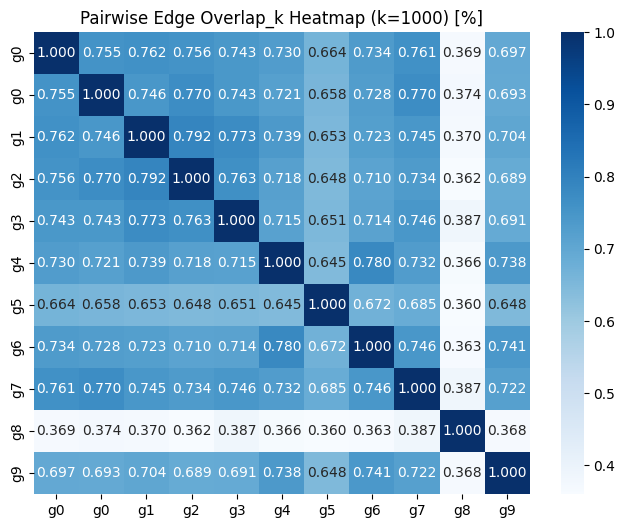

In [11]:
graphs_1 = create_graphs('graph_only/test',1000)
graphs_2 = create_graphs('graph_only/07-07-25',1000)
graphs_1.extend(graphs_2)
renamed_graphs = [(f'g{i}', graph) for i, (_, graph) in enumerate(graphs_1)]
renamed_graphs[0] = ('g0*', renamed_graphs[0][1])
edge_matrix = overlap_k(renamed_graphs, k =1000)
plot_edge_overlap(graphs_1, edge_matrix)

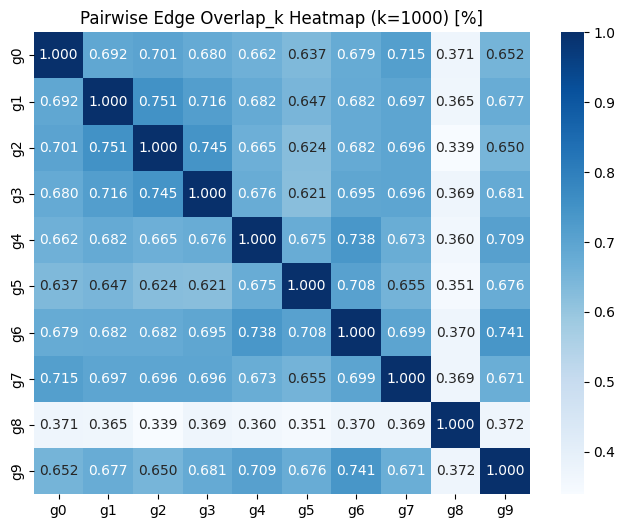

In [41]:
graphs = create_graphs('graph_only/07-07-25',100)
edge_matrix = overlap_k(graphs, k =1000)
plot_edge_overlap(graphs, edge_matrix)

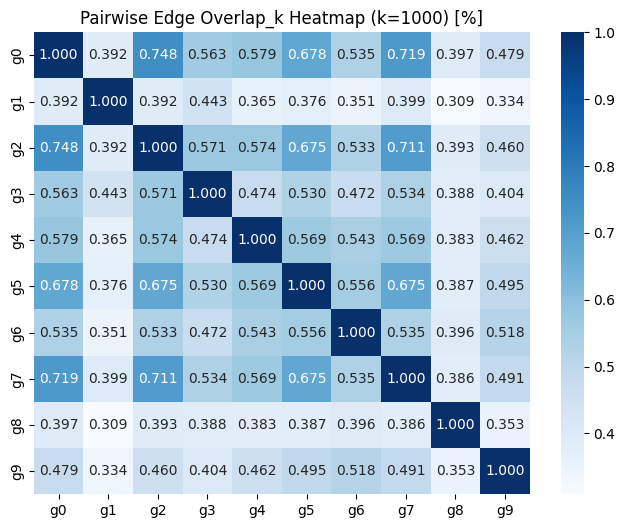

In [42]:
graphs = create_graphs('graph_only/07-07-25_no_prefix',600)
edge_matrix = overlap_k(graphs, k =1000)
plot_edge_overlap(graphs, edge_matrix)

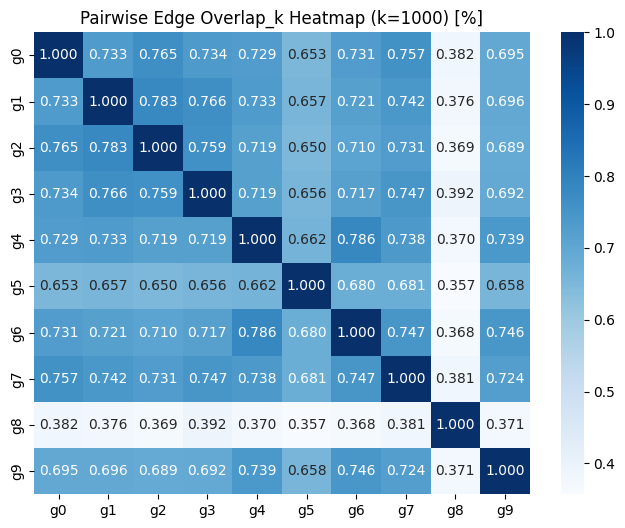

In [43]:
graphs = create_graphs('graph_only/07-07-25',600)
edge_matrix = overlap_k(graphs, k =1000)
plot_edge_overlap(graphs, edge_matrix)

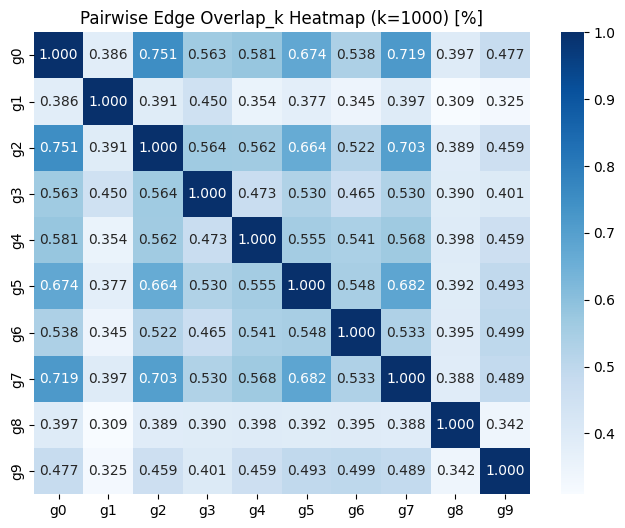

In [44]:
graphs = create_graphs('graph_only/07-07-25_no_prefix',1000)
edge_matrix = overlap_k(graphs, k =1000)
plot_edge_overlap(graphs, edge_matrix)

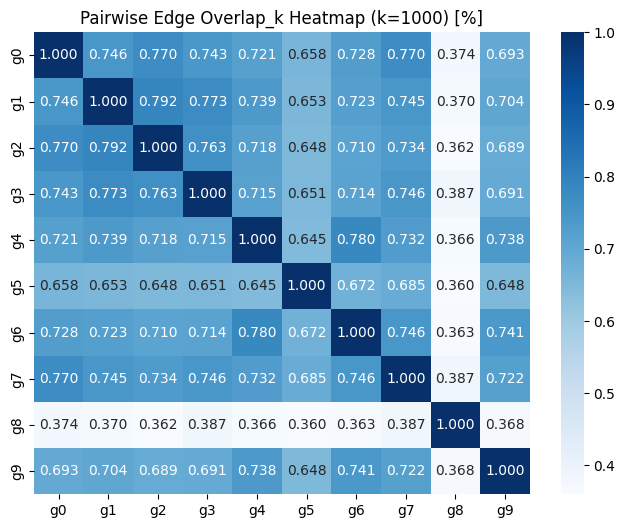

In [45]:
graphs = create_graphs('graph_only/07-07-25',1000)
edge_matrix = overlap_k(graphs, k =1000)
plot_edge_overlap(graphs, edge_matrix)

#### Weighted Jaccard Sim

In [ ]:
def topk_weighted_edges(G, k=None):
    if k is None:
        return {
            (u, v): abs(data.get("score", 0.0))
            for u, v, data in G.edges(data=True)
            if data.get("in_graph", False) is True
        }
    else:
        sorted_edges = sorted(
            G.edges(data=True),
            key=lambda e: abs(e[2].get("score", 0.0)),
            reverse=True
        )
        return {
            (u, v): abs(attr.get("score", 0.0))
            for u, v, attr in sorted_edges[:k]
        }

def weighted_jaccard_topk(G1, G2, k=None):
    edges1 = topk_weighted_edges(G1, k)
    edges2 = topk_weighted_edges(G2, k)
    print(edges1,edges2)

    all_edges = set(edges1.keys()).union(edges2.keys())
    numerator = sum(min(edges1.get(e, 0.0), edges2.get(e, 0.0)) for e in all_edges)
    denominator = sum(max(edges1.get(e, 0.0), edges2.get(e, 0.0)) for e in all_edges)
    return numerator / denominator if denominator > 0 else 0.0

def find_weighted_jaccard_topk_matrix(graphs, k=None):
    n = len(graphs)
    print(graphs)
    sim_matrix = np.zeros((n, n))
    np.fill_diagonal(sim_matrix, 1.0)

    for (i, (_, G1)), (j, (_, G2)) in itertools.combinations(enumerate(graphs), 2):
        sim = weighted_jaccard_topk(G1, G2, k)
        sim_matrix[i, j] = sim
        sim_matrix[j, i] = sim

    return sim_matrix

def plot_weighted_jaccard_similarity(graphs, sim_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, xticklabels=[name for name, _ in graphs],
                yticklabels=[name for name, _ in graphs], annot=True, fmt=".3f", cmap="Purples")
    plt.title("Pairwise Weighted Jaccard Similarity (All Edges)")
    plt.show()

In [29]:
graphs = create_graphs('graph_only/07-07-25',100)
jaccard_matrix = find_weighted_jaccard_topk_matrix(graphs)
plot_weighted_jaccard_similarity(graphs,jaccard_matrix)

[('g0', <networkx.classes.digraph.DiGraph object at 0x7908fc6a1610>), ('g1', <networkx.classes.digraph.DiGraph object at 0x7908f70946b0>), ('g2', <networkx.classes.digraph.DiGraph object at 0x7908baef5fd0>), ('g3', <networkx.classes.digraph.DiGraph object at 0x7908a0aab320>), ('g4', <networkx.classes.digraph.DiGraph object at 0x7908baef2990>), ('g5', <networkx.classes.digraph.DiGraph object at 0x7908bfda00e0>), ('g6', <networkx.classes.digraph.DiGraph object at 0x7909234523c0>), ('g7', <networkx.classes.digraph.DiGraph object at 0x7908b5c9bce0>), ('g8', <networkx.classes.digraph.DiGraph object at 0x790936ef9a00>), ('g9', <networkx.classes.digraph.DiGraph object at 0x79091b38d040>)]
set() set()


AttributeError: 'set' object has no attribute 'keys'

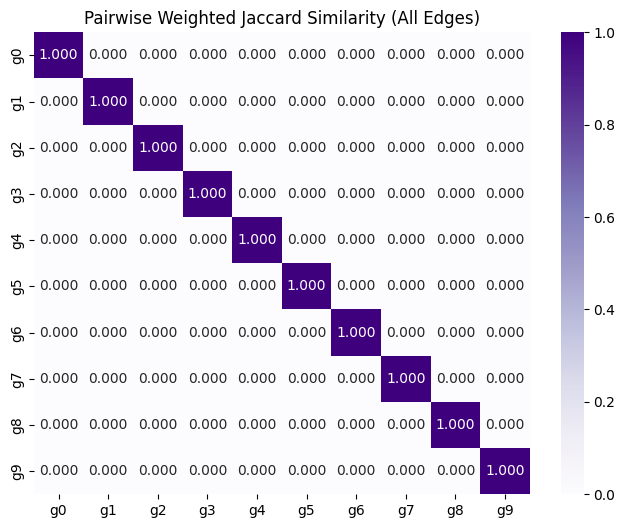

In [22]:
graphs = create_graphs('graph_only/07-07-25',600)
jaccard_matrix = find_weighted_jaccard_topk_matrix(graphs)
plot_weighted_jaccard_similarity(graphs,jaccard_matrix)

In [ ]:
graphs = create_graphs('graph_only/07-07-25',1000)
jaccard_matrix = find_weighted_jaccard_topk_matrix(graphs)
plot_weighted_jaccard_similarity(graphs,jaccard_matrix)